# Customer support agent built with LangGraph and PydanticAI

This notebook demonstrates how to build a customer support agent using **[LangGraph](https://langchain-ai.github.io/langgraph/concepts/why-langgraph/)** and **[Pydantic AI](https://ai.pydantic.dev/)**.

> **Note:** This notebook is only a demo and not intended for production use.

---

## LangGraph

LangGraph acts as a coordinator and flow controller, making it well-suited for building AI agents.  
It allows you to define the flow of a conversation as a graph, where each node represents a step in the process and edges define how the conversation progresses based on the current state.

---

## Pydantic AI

Pydantic AI is used to create type-safe and structured data models for information extracted by language models (LLMs).

This combination enables you to build robust, interactive agents that can reliably collect and process user input in real-world scenarios, while also providing more flexibility and control over the agent's behavior.

---

## Installing dependencies

In [16]:
%pip install langgraph pydantic-ai-slim[openai] --quiet

Note: you may need to restart the kernel to use updated packages.


---

## Preparing environment

In [17]:
from dotenv import load_dotenv
import os

load_dotenv(dotenv_path="./agentic_ai/customer_support_agent/.env")

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_BASE_URL = os.getenv("OPENAI_BASE_URL")

---

## Defining agent with Pydantic AI

#### Preparing LLM

In [18]:
from pydantic_ai.providers.openai import OpenAIProvider
from pydantic_ai.models.fallback import FallbackModel
from pydantic_ai.models.openai import OpenAIModel

# You can use any LLM that supports the OpenAI chat completion API.
# Or use corresponding model and provider from Pydantic AI.
gemini_flash_lite_2_5 = OpenAIModel(
    model_name="models/gemini-2.5-flash-lite",
    provider=OpenAIProvider(
        api_key=OPENAI_API_KEY,
        base_url=OPENAI_BASE_URL,
    ),
)

gemini_flash_2_5 = OpenAIModel(
    model_name="models/gemini-2.5-flash",
    provider=OpenAIProvider(
        api_key=OPENAI_API_KEY,
        base_url=OPENAI_BASE_URL,
    ),
)

# Fallback model that will be used if the first model fails.
# It will try to use gemini_flash_lite_2_5 first, and if it fails, it will use gemini_flash_2_5.
fallback_model = FallbackModel(gemini_flash_lite_2_5, gemini_flash_2_5)

#### A customer support agent used to answer users' questions

In [19]:
import datetime
from pydantic_ai import Agent, RunContext

from agentic_ai.customer_support_agent.service import Service
from dataclasses import dataclass


@dataclass
class CustomerSupportDeps:
    username: str
    service: Service


customer_support_instructions = """
You are a helpful customer support assistant for "Mobile Kingdom," a mobile phone shop.
Your main responsibility is to answer customer questions by exclusively using the provided tools to search for information.

- You should answer questions in a polite and warm manner to create a friendly atmosphere.
- Do not mention about the tools or how you are retrieving information.
- Base your answers solely on the information retrieved from the tools.
- If a question is ambiguous, ask for clarification.
- If the information is not available through the tools, just say you don't have that information.
- If a question is unrelated to the shop, state that you can only answer shop-related questions.
"""

CUSTOMER_SUPPORT_AGENT = "customer_support_agent"
customer_support_agent = Agent(
    deps_type=CustomerSupportDeps,
    name=CUSTOMER_SUPPORT_AGENT,
    model=fallback_model,
    instructions=customer_support_instructions,
    retries=1,
    output_type=str,
)


@customer_support_agent.instructions
def add_user_info(ctx: RunContext[CustomerSupportDeps]):
    return f"The customer's name is {ctx.deps.username}."


@customer_support_agent.instructions
def add_time():
    return f"Current time is {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"


@customer_support_agent.tool
def get_shop_information(ctx: RunContext[CustomerSupportDeps]):
    """
    Get information about the shop, such as opening hours, address, contact information, etc.
    """
    return ctx.deps.service.get_shop_info()


@customer_support_agent.tool
def get_stock_information(ctx: RunContext[CustomerSupportDeps]):
    """
    Get information about the items and quantities in stock.
    """
    return ctx.deps.service.get_stocks()


# Run the agent with a sample question
deps = CustomerSupportDeps(username="Kevin", service=Service())
print(
    await customer_support_agent.run(
        "What are the opening hours of the shop?", deps=deps
    )
)
print(await customer_support_agent.run("What items are in stock?", deps=deps))
print(await customer_support_agent.run("Can you tell me about the menu?", deps=deps))
print(await customer_support_agent.run("I want to order a pizza.", deps=deps))

AgentRunResult(output='Hello Kevin! Mobile Kingdom is open from 9:00 AM to 9:00 PM on Mondays through Thursdays, 9:00 AM to 10:00 PM on Fridays, 10:00 AM to 10:00 PM on Saturdays, and 10:00 AM to 8:00 PM on Sundays.')
AgentRunResult(output="We currently have the following items in stock:\n\n*   **Iphone 14**: 48 available, priced at $999.99. This is the latest model of Apple's smartphone with advanced features.\n*   **Samsung Galaxy S22**: 30 available, priced at $899.99. This is a flagship smartphone from Samsung with high-end specifications.\n*   **Google Pixel 6**: 20 available, priced at $599.99. This is Google's latest smartphone with a stock Android experience.\n*   **OnePlus 9**: 25 available, priced at $749.99. This is a high-performance smartphone with fast charging capabilities.\n\nLet me know if you'd like to know more about any of these models or if there's anything else I can help you with!")
AgentRunResult(output="I'm sorry, I can only help with mobile phone-related quest

#### An order agent used to help users manage the shopping cart

In [20]:
import datetime
from pydantic_ai import Agent, RunContext
from pydantic_ai.tools import Tool

from agentic_ai.customer_support_agent.service import Service
from dataclasses import dataclass


@dataclass
class ShoppingSupportDeps:
    username: str
    service: Service


shopping_support_instructions = """
You are a helpful shopping support assistant for "Mobile Kingdom," a mobile phone shop.
Your only responsibility is to help customers buy mobile phones. 
Before answering any question, you should search for information using the provided tools.


- Before adding an item to the cart, you should check if the item is in stock and the quantity requested is available.
- If the item is in stock, add it to the cart with the EXACT NAME that matches the stock item.
- If the item is not in stock, inform the customer that the item is not available.
- When removing an item from the cart, check if the item exists in the cart.
- You should answer questions in a polite and warm manner to create a friendly atmosphere.
- Do not mention about the tools or how you are retrieving information.
- Base your answers solely on the information retrieved from the tools.
- If a question is ambiguous, ask for clarification.
- If the information is not available through the tools, just say you don't have that information.
"""

SHOPPING_SUPPORT_AGENT = "shopping_support_agent"
shopping_support_agent = Agent(
    deps_type=ShoppingSupportDeps,
    name=SHOPPING_SUPPORT_AGENT,
    model=fallback_model,
    instructions=shopping_support_instructions,
    retries=1,
    output_type=str,
)


@shopping_support_agent.instructions
def add_user_info(ctx: RunContext[ShoppingSupportDeps]):
    return f"The customer's name is {ctx.deps.username}."


@shopping_support_agent.instructions
def add_time():
    return f"Current time is {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"


@shopping_support_agent.instructions
def add_stock_information(ctx: RunContext[ShoppingSupportDeps]):
    stock_items = ctx.deps.service.get_stocks()
    return f"The following items are in stock\n <stocks> {stock_items} </stocks>."


@shopping_support_agent.tool
def add_to_cart(ctx: RunContext[ShoppingSupportDeps], item: str, quantity: int):
    """
    Add an item to the cart.

    #### Args
    - item: The name of the item to add to the cart.
    - quantity: The quantity of the item to add to the cart.
    """
    ctx.deps.service.add_to_cart(item, quantity)

@shopping_support_agent.tool
def remove_from_cart(ctx: RunContext[ShoppingSupportDeps], item: str, quantity: int):
    """
    Remove an item from the cart.

    #### Args
    - item: The name of the item to remove from the cart.
    - quantity: The quantity of the item to remove from the cart.
    """
    ctx.deps.service.remove_from_cart(item, quantity)

@shopping_support_agent.tool
def get_cart(ctx: RunContext[ShoppingSupportDeps]):
    """
    Get the items in the cart.
    """
    return ctx.deps.service.get_cart()

@shopping_support_agent.tool
def checkout(ctx: RunContext[ShoppingSupportDeps]):
    """
    Process the checkout of the items in the cart.
    """
    return ctx.deps.service.checkout()


# Run the agent with a sample question
deps = ShoppingSupportDeps(username="Kevin", service=Service())
print(await shopping_support_agent.run("I want to buy 2 Iphone 14", deps=deps))
print(await shopping_support_agent.run("What items are in my cart?", deps=deps))
print(await shopping_support_agent.run("Checkout", deps=deps))
print(await shopping_support_agent.run("What items are in stock?", deps=deps))

AgentRunResult(output="I've added 2 units of the iPhone 14 to your cart, Kevin! Let me know if there's anything else you'd like to add.")
AgentRunResult(output='Hello Kevin! It looks like you have 2 iPhone 14s in your cart. Is there anything else I can help you with today?')
AgentRunResult(output='Thank you for shopping with us, Kevin! Your total amount is $1999.98 for 2 Iphone 14s.')
AgentRunResult(output="Hello Kevin! We have a wonderful selection of phones in stock right now:\n\n*   **Iphone 14**: We have 46 units available at $999.99 each. It's the latest model with advanced features!\n*   **Samsung Galaxy S22**: We have 30 units available at $899.99 each. This is a flagship phone with high-end specifications.\n*   **Google Pixel 6**: We have 20 units available at $599.99 each. Experience the latest Android with this one!\n*   **OnePlus 9**: We have 25 units available at $749.99 each. It's a high-performance phone with fast charging.\n\nIs there anything that catches your eye, Kevi

#### Input classifier

In [21]:
from pydantic_ai import Agent, ModelRetry
from pydantic import BaseModel
from enum import Enum


class Tag(str, Enum):
    SHOPPING_SUPPORT = SHOPPING_SUPPORT_AGENT
    CUSTOMER_SUPPORT = CUSTOMER_SUPPORT_AGENT


class InputClassifierOutput(BaseModel):
    tag: Tag


input_classifier_instructions = f"""
You are a helpful ai assistant classifier user's input.

If the input is related to check or update shopping cart, return "{SHOPPING_SUPPORT_AGENT}" else return "{CUSTOMER_SUPPORT_AGENT}".
"""

INPUT_CLASSIFIER = "input_classifier"
input_classifier = Agent(
    name=INPUT_CLASSIFIER,
    model=fallback_model,
    instructions=input_classifier_instructions,
    retries=1,
    output_type=InputClassifierOutput,
)


@input_classifier.output_validator
def validate_result(_, result: InputClassifierOutput) -> InputClassifierOutput:
    if result.tag not in [Tag.SHOPPING_SUPPORT, Tag.CUSTOMER_SUPPORT]:
        raise ModelRetry(
            f"Invalid tag. Please choose from `{Tag.SHOPPING_SUPPORT}` and `{Tag.CUSTOMER_SUPPORT}`"
        )

    return result


# Run the agent with a sample question
print(await input_classifier.run("I want to buy 2 iPhone 14"))
print(await input_classifier.run("What items are in my cart?"))
print(await input_classifier.run("Checkout"))
print(await input_classifier.run("What items are in stock?"))
print(await input_classifier.run("Who are you?"))
print(await input_classifier.run("I am looking for a mobile phone shop."))

AgentRunResult(output=InputClassifierOutput(tag=<Tag.SHOPPING_SUPPORT: 'shopping_support_agent'>))
AgentRunResult(output=InputClassifierOutput(tag=<Tag.SHOPPING_SUPPORT: 'shopping_support_agent'>))
AgentRunResult(output=InputClassifierOutput(tag=<Tag.SHOPPING_SUPPORT: 'shopping_support_agent'>))
AgentRunResult(output=InputClassifierOutput(tag=<Tag.CUSTOMER_SUPPORT: 'customer_support_agent'>))
AgentRunResult(output=InputClassifierOutput(tag=<Tag.CUSTOMER_SUPPORT: 'customer_support_agent'>))
AgentRunResult(output=InputClassifierOutput(tag=<Tag.CUSTOMER_SUPPORT: 'customer_support_agent'>))


---

## Applying agents in LangGraph

#### State

In [22]:
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from agentic_ai.customer_support_agent.service import Service

class GraphState(TypedDict):
    """State that the graph will maintain during the conversation."""    
    # chat history of the conversation
    messages: Annotated[
        list[AnyMessage], add_messages # use add_messages to append messages to the chat history
    ]
    user_input: str
    username: str
    service: Service

#### Nodes

In [23]:
from langchain_core.messages import AIMessage

async def customer_support_node(state: GraphState):
    """A node that handles customer support queries."""
    res = await customer_support_agent.run(state['user_input'], deps=CustomerSupportDeps(username=state['username'], service=state['service']))
    return {
        "messages":[AIMessage(content=res.output)],
    }

async def shopping_support_node(state: GraphState):
    """A node that handles shopping support queries."""
    res = await shopping_support_agent.run(state['user_input'], deps=ShoppingSupportDeps(username=state['username'], service=state['service']))
    return {
        "messages":[AIMessage(content=res.output)],
    }

#### Edges

In [ ]:
async def route_entry_point(state: GraphState):
    """Entry point for the routing graph."""
    # Use the input classifier to determine which agent to route the query to
    res = await input_classifier.run(state['user_input'])
    return res.output.tag.value

### Combining state, nodes, and edges in a single graph

In [25]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langchain_core.messages import HumanMessage


builder = StateGraph(GraphState)

builder.add_node(CUSTOMER_SUPPORT_AGENT, customer_support_node)
builder.add_node(SHOPPING_SUPPORT_AGENT, shopping_support_node)

builder.set_conditional_entry_point(route_entry_point, {CUSTOMER_SUPPORT_AGENT: CUSTOMER_SUPPORT_AGENT, SHOPPING_SUPPORT_AGENT: SHOPPING_SUPPORT_AGENT})
graph = builder.compile(checkpointer=MemorySaver())

---

## Visualizing the agent workflow

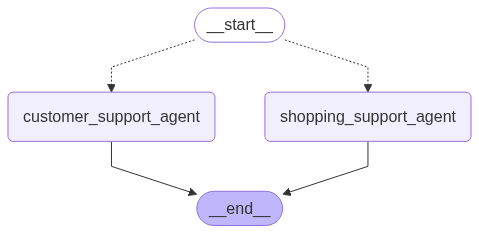

In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")

---

## Interacting with our agent

In [27]:
from langchain_core.runnables.config import RunnableConfig
import uuid
from agentic_ai.customer_support_agent.service import Service

config = RunnableConfig(
    configurable={"thread_id": str(uuid.uuid4())},
    recursion_limit=5, # Set recursion limit to avoid deep recursion issues
)

async def stream_graph_updates(user_input: str):
    init_state: GraphState = {
        "messages": [HumanMessage(content=user_input)],
        "user_input": user_input,
        "username": "Kevin",  # You can change this to any username you want
        "service": Service()  # Initialize the service to access shop information
    }
    async for event in graph.astream(init_state, config=config):
        for value in event.values():
            value["messages"][-1].pretty_print()

while True:
    try:
        user_input = input("User: (q/Q to quit) ")
        print('='*32 + ' \033[1mHuman Message\033[0m ' + '='*32)
        print(user_input)

        if user_input.lower() in ["q"]:
            print("Goodbye!")
            break
        await stream_graph_updates(user_input)
    except Exception as e:
        print("Error occurred: ", e)
        break

================================ Human Message ================================
When is this shop open?
Input classifier result: customer_support_agent
Error occurred:  Type is not msgpack serializable: Service
